# Defining the Fully Convolutional Neural Network

In [1]:
import os
import cv2
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pickle

from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class FCNN(nn.Module):
    """
    This is a class for fully convolutional neural networks.
    
    It is a subclass of the Module class from torch.nn.
    See the torch.nn documentation for more information.
    """
    
    def __init__(self):
        """
        The constructor for FCNN class. The internal states of the network are initialized. 
        """
        
        super(FCNN, self).__init__()
        self.conv0 = nn.Conv2d(in_channels=1, out_channels=30, kernel_size=2, stride=2)
        
        self.conv1 = nn.Conv2d(in_channels=30, out_channels=30, kernel_size=5, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=30, out_channels=60, kernel_size=3, stride=1)
        self.conv2_drop = nn.Dropout2d()
        
        self.conv3 = nn.Conv2d(in_channels=60, out_channels=60, kernel_size=3, stride=2)
        self.conv3_drop = nn.Dropout2d()
        
        self.conv4 = nn.Conv2d(in_channels=60, out_channels=120, kernel_size=3, stride=1)
        
        self.conv5 = nn.Conv2d(in_channels=120, out_channels=120, kernel_size=3, stride=1)
        
        self.conv6 = nn.Conv2d(in_channels=120, out_channels=1, kernel_size=1, stride=1)
        
        
    def forward(self, data):
        """
        Defines the computation performed at every call.
        
        Parameters:
            data (4D-tensor): The input that is evaluated by the network.
            
        Returns:
            x (tensor): The output of the network after evaluating it on the given input.
        """
        
        x = F.relu(self.conv0(data))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2_drop(self.conv2(x)))
        x = F.relu(self.conv3_drop(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = torch.sigmoid(self.conv6(x))
        return x

In [23]:
# Create a new instance of the FCNN class. This will be our network.      
new_network = FCNN().to(device)

In [24]:
#Which optimizer and criterion should we choose? Perform best?
criterion = nn.MSELoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

In [25]:
for param_tensor in new_network.state_dict():
    print(param_tensor, "\t", new_network.state_dict()[param_tensor].size())

print("")
print("")
print("")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

conv0.weight 	 torch.Size([30, 1, 2, 2])
conv0.bias 	 torch.Size([30])
conv1.weight 	 torch.Size([30, 30, 5, 5])
conv1.bias 	 torch.Size([30])
conv2.weight 	 torch.Size([60, 30, 3, 3])
conv2.bias 	 torch.Size([60])
conv3.weight 	 torch.Size([60, 60, 3, 3])
conv3.bias 	 torch.Size([60])
conv4.weight 	 torch.Size([120, 60, 3, 3])
conv4.bias 	 torch.Size([120])
conv5.weight 	 torch.Size([120, 120, 3, 3])
conv5.bias 	 torch.Size([120])
conv6.weight 	 torch.Size([1, 120, 1, 1])
conv6.bias 	 torch.Size([1])



state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [140439281472960, 140439281473984, 140439281474112, 140439281474176, 140439281474048, 140439281474368, 140439281474240, 140439281474560, 140439281474688, 140439281474624, 140439281474432, 140439281474880, 140439281474752, 140439281475072]}]


In [43]:
summary(network, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 30, 32, 32]             150
            Conv2d-2           [-1, 30, 14, 14]          22,530
            Conv2d-3           [-1, 60, 12, 12]          16,260
         Dropout2d-4           [-1, 60, 12, 12]               0
            Conv2d-5             [-1, 60, 5, 5]          32,460
         Dropout2d-6             [-1, 60, 5, 5]               0
            Conv2d-7            [-1, 120, 3, 3]          64,920
            Conv2d-8            [-1, 120, 1, 1]         129,720
            Conv2d-9              [-1, 1, 1, 1]             121
Total params: 266,161
Trainable params: 266,161
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.44
Params size (MB): 1.02
Estimated Total Size (MB): 1.47
-------------------------------------------

# Loading the samples

In [4]:
POLLEN_DATA_CREATED = False
cur_dir = os.getcwd()
pollen_files = cur_dir + '/Datasets/PollenDataSmall/'
np_pollen_data = []     # single date will be [img,label]


if not POLLEN_DATA_CREATED:
    for folder in next(os.walk(pollen_files))[1]:
        if folder == 'p':
            label = 1
        else:
            label = 0
        parent_path = os.path.join(pollen_files, folder)
        for file in os.listdir(parent_path):
            if '.png' in file:
                try:
                    path = os.path.join(parent_path, file)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    np_pollen_data.append([np.array(img), label])
                except Exception as e:
                    print(folder, file, str(e))

    np.random.shuffle(np_pollen_data)
    print("Data created.")


Data created.


In [5]:
# seperate the images and the corresponding labels into two lists:

images = []
labels = []

for i in range(len(np_pollen_data)):
    images.append(np_pollen_data[i][0])
    labels.append(np_pollen_data[i][1])

print(len(images))

20700


In [6]:
# Split the data into train and validation set;
# we do not want to test the network on the data we already used for the training.

train_x = images[:int(len(images)*0.4)]
train_y = labels[:int(len(images)*0.4)]
valid_x = images[int(len(images)*0.4):int(len(images)*0.5)]
valid_y = labels[int(len(images)*0.4):int(len(images)*0.5)]

In [7]:
print(images[1].shape)

(64, 64)


In [8]:
# Our neural network expects a dataloader. Thus, we 

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(train_x),torch.Tensor(train_y)),batch_size=32)
validloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(valid_x),torch.Tensor(valid_y)),batch_size=100)

# Train the Network

First we have a look at the performance of the untrained model on our validation set. 

In [13]:
ep = 10
threshold = 0.8

#Which optimizer and criterion should we choose? Perform best?
criterion = nn.MSELoss()
optimizer = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)


### Validation

In [9]:
def validate(network, testloader):
    """
    Calculates the mean validation loss, the F1-Score and the accuracy of the given network on the testloader data.
    
    Parameters:
        network (): The network to validate. 
        testloader (torch.utils.data.DataLoader): Contains the data which is used to validate the network. 
        
    Returns:
        validation_loss (): The mean loss per image with regards to a fixed criterion.
        F1_Score (): The harmonic mean of the precision and the recall of the given network
            on the given validation data.
        correct / total (): The percentage of correctly classified samples of the total number of validation samples.
        
    """
    
    total = 0
    correct = 0
    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    # We do not need any gradiants here, since we do not train the network.
    # We are only interested in the predictions of the network on the testdata. 
    with torch.no_grad():
        validation_loss = 0
        for i, (inputs, labels) in enumerate(testloader):
            
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            #print(labels.size(0))
            loss = criterion(outputs,labels)
            validation_loss += loss.item()
            predicted = (outputs >= threshold) # Predicted is a tensor of booleans 
            total += labels.size(0)
            predicted = predicted.view(predicted.size(0)) 
            #print(labels.size())
            #print((predicted == labels).sum().item())
            labels = labels == 1
            correct += (predicted == labels).sum().item()
            true_positive += (predicted & labels).sum().item()
            false_negative += (torch.logical_not(predicted) & labels).sum().item()
            false_positive += (predicted & torch.logical_not(labels)).sum().item()
            true_negative += (torch.logical_not(predicted) & torch.logical_not(labels)).sum().item()
            
        validation_loss = validation_loss / total 
        
        try: 
            recall = true_positive / (true_positive + false_negative)
        except ZeroDivisionError:
            recall = 0
        try:
            precision = true_positive / (true_positive + false_positive)
        except ZeroDivisionError:
            precision = 0
        try:
            F1_score = 2 * (precision * recall) / (precision + recall)
        except ZeroDivisionError:
            F1_score = 0
            
    
    print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
    print('F1 Score of the network on the test images: %f' % F1_score)
    return validation_loss, F1_score, (correct / total)

In [ ]:
validate(network, validloader)

### Training

In [7]:
# from pytorch blitz tutorial

def train(network, trainloader, ep, criterion, optimizer, print_interval):
    """
    Train a neural network.
    
    
    Parameters:
        network ():
        trainloader ():
        ep (int): The number of epochs the network will be trained for.
        criterion ():
        optimizer ():
        print_interval (int): The number of batches after which the function prints the loss for one batch.
    
    Returns:
        train_losses ([float]): The mean of the loss for one train sample after every epoch. 
        validation_losses ([float]): The mean of the loss for one validation sample after every epoch.
        F1 ([float]): The F1-Score of the validation data after every epoch.
        accuracy ([float]): The accuracy of the network on the validation data after every epoch.
    """
    
    losses = [] # Mean of loss/image in every epoch of training 
    validation_losses = []
    F1 = []
    accuracy = []
    validate(network, validloader)
    
    for epoch in range(ep):

        loss_stats = 0.0
        total = 0
        
        running_loss = 0.0
    
        for i, (inputs, lables) in enumerate(trainloader):
            
            inputs, lables = inputs.to(device), lables.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            #print(lables.shape)
            
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            #print(outputs.shape)
            loss = criterion(outputs, lables)
            loss.backward() #propagate the error back through the network
            optimizer.step() #adjust the weights of the network depending on the propagated error
    
            #that's it.
            total += lables.shape[0]
            
            #Some statistics:
            running_loss += loss.item()
            
            loss_stats += loss.item()
            
            if i % print_interval == print_interval - 1:    # print every x mini-batches (loss for one batch)
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / print_interval))
                running_loss = 0.0
        
        losses.append(loss_stats / total)
        #Test the network using the validation set after every epoch of training.
        val_loss_curr, F1_curr, accuracy_curr = validate(network, validloader)
        validation_losses.append(val_loss_curr)
        F1.append(F1_curr)
        accuracy.append(accuracy_curr)
        
    print('Finished Training')
    return losses, validation_losses, F1, accuracy


In [ ]:
train_losses, val_losses, F1_scores, accuracies = train(network, trainloader, ep, criterion, optimizer, 32)

### Save Network and Metadata

In [35]:
cur_dir = os.getcwd()
save_path = cur_dir + '/supernet.pt'

In [13]:
# save the networks parameters to have the possibility to reload them later:

torch.save(network.state_dict(), save_path)

In [14]:
# save the corresponding losses, F1-Scores and Accuracies using pickle:

with open('train_losses.obj', 'wb') as train_losses_file:
    pickle.dump(train_losses, train_losses_file)

with open('val_losses.obj', 'wb') as val_losses_file:
    pickle.dump(val_losses, val_losses_file)
    
with open('F1.obj', 'wb') as F1_file:
    pickle.dump(F1_scores, F1_file)
    
with open('accuracies.obj', 'wb') as accuracies_file:
    pickle.dump(accuracies, accuracies_file)

### Load Network

In [36]:
# Load saved network

pollen_network = FCNN()
# print(pollen_network.conv0.weight)
pollen_network.load_state_dict(torch.load(save_path))
pollen_network.eval()
# print(pollen_network.conv0.weight)

FCNN(
  (conv0): Conv2d(1, 30, kernel_size=(2, 2), stride=(2, 2))
  (conv1): Conv2d(30, 30, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (conv3): Conv2d(60, 60, kernel_size=(3, 3), stride=(2, 2))
  (conv3_drop): Dropout2d(p=0.5, inplace=False)
  (conv4): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(120, 120, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(120, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [28]:
criterion = nn.MSELoss()
optimizer = optim.SGD(pollen_network.parameters(), lr=0.001, momentum=0.9)

In [20]:
for param_tensor in pollen_network.state_dict():
    print(param_tensor, "\t", pollen_network.state_dict()[param_tensor].size())

print("")
print("")
print("")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

conv0.weight 	 torch.Size([30, 1, 2, 2])
conv0.bias 	 torch.Size([30])
conv1.weight 	 torch.Size([30, 30, 5, 5])
conv1.bias 	 torch.Size([30])
conv2.weight 	 torch.Size([60, 30, 3, 3])
conv2.bias 	 torch.Size([60])
conv3.weight 	 torch.Size([60, 60, 3, 3])
conv3.bias 	 torch.Size([60])
conv4.weight 	 torch.Size([120, 60, 3, 3])
conv4.bias 	 torch.Size([120])
conv5.weight 	 torch.Size([120, 120, 3, 3])
conv5.bias 	 torch.Size([120])
conv6.weight 	 torch.Size([1, 120, 1, 1])
conv6.bias 	 torch.Size([1])



state 	 {}
param_groups 	 [{'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [140439281433472, 140439077857088, 140439280995648, 140439077893696, 140439077894272, 140439077894848, 140439077893056, 140439077895232, 140439077893568, 140439077894144, 140439077893888, 140439077893248, 140439077892864, 140439077894912]}]


# Validation

The performance on the validation data after training:

In [37]:
validate(pollen_network, validloader) #(Validation wird direkt mit dem Training gemacht. Nach jeder Epoche.)

Accuracy of the network on the test images: 90 %
F1 Score of the network on the test images: 0.436578


(0.0009238954327532634, 0.4365781710914455, 0.9077294685990338)

# Plot Losses

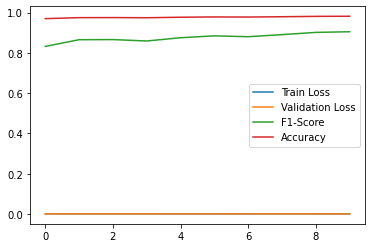

In [15]:
import matplotlib.pyplot as plt 

plt.plot(train_losses)
plt.plot(val_losses)
plt.plot(F1_scores)
plt.plot(accuracies)
plt.legend(["Train Loss", "Validation Loss", "F1-Score", "Accuracy"])
plt.show()

#### Plot some wrong classified samples.


In [36]:
printloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.Tensor(valid_x), torch.Tensor(valid_y)), batch_size=1)

NameError: name 'valid_x' is not defined

In [ ]:
# This function was used to find the weaknesses of the network.

def print_false_positive(network, testloader):
    """
    Evaluates the network and prints the false positives samples. 
    
    Parameters:
    
    Returns:
    
    """
    
    counter = 0
    # We do not need any gradiants here, since we do not train the network.
    # We are only interested in the predictions of the network on the testdata. 
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            predicted = (outputs >= threshold) # Predicted is a tensor of booleans 
            predicted = predicted.view(predicted.size(0))
            labels = labels == 1
            if (predicted and not labels):
                title = 'Label: False, Predicted: True'
                fig, ax = plt.subplots()
                plt.imshow(np.array(inputs[0]), cmap='gray')
                ax.set_title(title)
                plt.show()
                counter += 1
                if counter == 20:
                    break
    return counter 
    
print_false_positive(network, printloader)

In [ ]:
def print_false_negative(network, testloader):
    # We do not need any gradiants here, since we do not train the network.
    # We are only interested in the predictions of the network on the testdata. 
    counter = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            outputs = network(torch.transpose(inputs[...,None],1,3)).view(-1)
            predicted = (outputs >= threshold) # Predicted is a tensor of booleans 
            predicted = predicted.view(predicted.size(0))
            labels = labels == 1
            if (not predicted and labels):
                title = 'Label: True, Predicted: False'
                fig, ax = plt.subplots()
                plt.imshow(np.array(inputs[0]), cmap='gray')
                ax.set_title(title)
                plt.show()
                counter += 1
                if counter == 20:
                    break
    return counter
    
print_false_negative(network, printloader)

# Create Heatmaps of Full Size Images

We start with loading some full size images:

In [10]:
def get_samples(dir):
    """returns samples in given directory"""

    # samples will be a list of tuples, each tuple contains a path and a list of coords of a single image
    samples = []
    for root, folders, files in os.walk(dir):
        for folder in folders:
            if folder == 'img':
                for img_root, img_folder, img_files in os.walk(os.path.join(root, folder)):
                    for img_file in img_files:
                        # go find its related annotation file:
                        found_ann = False
                        for ann_root, ann_folder, ann_files in os.walk(os.path.join(root, 'ann')):
                            if found_ann:
                                break
                            for ann_file in ann_files:
                                if img_file in ann_file:
                                    # found a pair!
                                    cur_coords = []
                                    with open(os.path.join(ann_root, ann_file)) as ann_json:
                                        ann_data = json.load(ann_json)
                                    cur_len = len(ann_data['objects'])
                                    if cur_len:
                                        for obj in ann_data['objects']:
                                            cur_coords.append(obj['points']['exterior'][0])
                                        img_path = os.path.join(img_root, img_file)
                                        np_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                                        samples.append((np.array(np_img), cur_coords))
                                    # to prevent unnecessary looping:
                                    found_ann = True
                                    break
    return samples

In [11]:
cur_dir = os.getcwd()
full_size_path = cur_dir + '/Fullsize/'
full_size_images = get_samples(full_size_path)

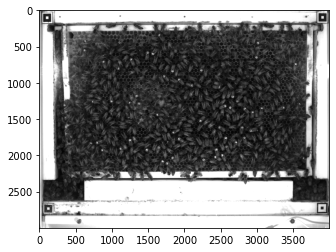

In [12]:
# show one of the full size images:

plt.imshow(full_size_images[0][0], cmap='gray')
plt.show()

### Create Loader with Fullsizeimages

In [14]:
# fs_images = []
# fs_coords = []

# for i in range(len(full_size_images)):
#     fs_images.append(full_size_images[i][0])
#     fs_coords.append(full_size_images[i][1])

# print(len(fs_images))
# t_images = torch.Tensor(fs_images)[None, ...]
# TODO

10


In [17]:
def heat(network, samples):
    """
    Feeds images of any size into the network and returns the belonging heatmaps. 
    
    Parameters:
        network (FCNN): A fully convolutional neural network, that is used to compute a heatmap.
        testloader (torch.utils.data.DataLoader): Dataloader with batch size 1 that contains the
            images you want to compute the heatmaps of
        
    Returns:
        heatmaps ([np.array]): A list which contains a heatmap that is a 2D array for every input image.
    """
    
    heatmaps = []
    print('Creating heatmaps...')
    with torch.no_grad():

        for fs_image, fs_coords in samples:
            t_image = torch.Tensor(fs_image)[None, ...]
            # outputs = network(torch.transpose(inputs[...,None],1,3))
            heatmap = network(torch.transpose(t_image[...,None],1,3))
            heatmaps.append((np.array(torch.transpose(heatmap[0,0,:,:],0,1)),fs_coords))
            
    print('Heatmaps created.')
    return heatmaps

In [18]:
heatmaps = heat(network,full_size_images)

Creating heatmaps...
Heatmaps created.


In [19]:
print(heatmaps[0][0].shape)

(368, 493)


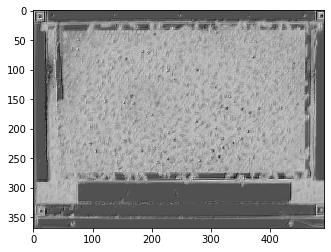

In [22]:
plt.imshow(heatmaps[0][0], interpolation = 'none', cmap = 'gray')
plt.show()

In [21]:
# Find the local maxima using max pooling:

def non_max_suppression(heatmaps, local_size = 8):
    heatmaps_sup = []
    pooling = nn.MaxPool2d((local_size * 2 - 1), stride = 1, padding = local_size - 1)
    for heatmap in heatmaps:
        max_filter = pooling(torch.tensor(heatmap)[None,...])
        max_filter = np.array(max_filter)
        heatmap = ((heatmap == max_filter) * (heatmap >= 0.8)).astype(int)
        heatmaps_sup.append(heatmap[0,:,:])
        
    return heatmaps_sup

def non_max_suppression_single(heatmap, local_size = 8):
    pooling = nn.MaxPool2d((local_size * 2 - 1), stride = 1, padding = local_size - 1)
    max_filter = pooling(torch.tensor(heatmap)[None,...])
    max_filter = np.array(max_filter)
    heatmap = ((heatmap == max_filter) * (heatmap >= 0.8)).astype(int)
    heatmap_sup = heatmap[0,:,:]
        
    return heatmap_sup

In [35]:
local = non_max_suppression([heatmaps[0]],16)

In [35]:
non_max_heatmaps = [(non_max_suppression_single(heatmap),coords) for heatmap, coords in heatmaps]

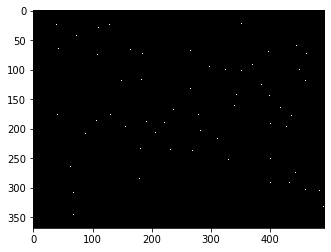

In [36]:
plt.imshow(local[0], interpolation = 'none', cmap = 'gray')
plt.show()

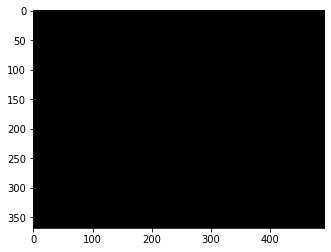

In [32]:
plt.imshow(non_max_heatmaps[3][0], interpolation = 'none', cmap = 'gray')
plt.show()

In [55]:
# Get coordinates of local maxima and convert back to full image size coordinates:

def pollen_coordinates(heatmap):
    coordinate_list = []
    h_coordinates = np.argwhere(heatmap == 1)
    for i in range(h_coordinates.shape[0]):
        coordinate_list.append((h_coordinates[i,0] * 2 * 2 * 2 + 28, h_coordinates[i,1] * 2 * 2 * 2 + 28))
    return coordinate_list
    

In [ ]:
image = Image.fromarray(np.uint8(cm.gray(first_heatmap)*255))

In [ ]:
plt.imshow(image, interpolation = 'none')
plt.show()

In [ ]:
image_rescaled = image.resize((4000,3000))

In [ ]:
plt.imshow(image_rescaled, interpolation = 'none')
plt.show()

# Plot Heatmap: Predicted Pollen vs Real Pollen

In [2]:
def guess_plotter(img, network_guess, actual_points):

    np_img = np.array(Image.open(img), dtype=np.uint8)
    main_fig,ax = plt.subplots(1)
    ax.imshow(np_img)

    for coord in actual_points:
        crcl = patches.Circle((coord[0],coord[1]),35,linewidth=4,edgecolor='r',facecolor='none')
        ax.add_patch(crcl)

    for coord in network_guess:
        crcl = patches.Circle((coord[0],coord[1]),20,linewidth=2,edgecolor='b',facecolor='none')
        ax.add_patch(crcl)

    plt.show()

In [ ]:
## We need something like:
# our_images = get_samples('/dir/to/Fullsize/Images')
# for image, coords in our_images:
#     heatimage = heat(network,image_as_loader)
#     local = non_max_suppression([heatimage],16)
#     gussed_coords = pollen_coordinates(local)
#     guess_plotter(image,guessed_coords,coords)